In [1]:
import os 
from glob import glob

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_paths = glob('cifar/train/*.png')

이미지 확인하기 

In [3]:
path = data_paths[0]
path

'cifar/train\\0_frog.png'

In [4]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)

In [5]:
image.shape

TensorShape([32, 32, 3])

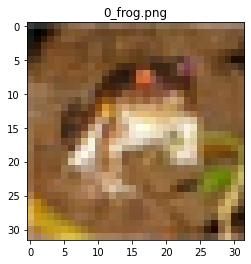

In [6]:
plt.title(os.path.basename(path))
plt.imshow(image)
plt.show()

### tf.data

tf.data를 이용해서 이미지 읽기

In [8]:
data_paths[:10]

['cifar/train\\0_frog.png',
 'cifar/train\\10000_automobile.png',
 'cifar/train\\10001_frog.png',
 'cifar/train\\10002_frog.png',
 'cifar/train\\10003_ship.png',
 'cifar/train\\10004_ship.png',
 'cifar/train\\10005_cat.png',
 'cifar/train\\10006_deer.png',
 'cifar/train\\10007_frog.png',
 'cifar/train\\10008_airplane.png']

In [9]:
def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    return image

In [11]:
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
dataset = dataset.map(read_image)

In [13]:
tf_image = next(iter(dataset))
tf_image.shape

TensorShape([32, 32, 3])

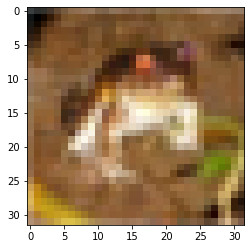

In [14]:
plt.imshow(tf_image)
plt.show()

### batch로 묶기

In [17]:
batch_size = 8

In [18]:
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
dataset = dataset.map(read_image)
dataset = dataset.batch(batch_size)

In [19]:
tf_image = next(iter(dataset))
tf_image.shape

TensorShape([8, 32, 32, 3])

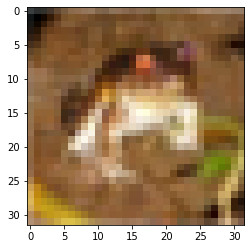

In [20]:
plt.imshow(tf_image[0])

### shuffle 하기

In [22]:
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
dataset = dataset.map(read_image)
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(buffer_size = len(data_paths)) # 공식홈페이지에서 데이터 개수만큼 넣으라고 했다

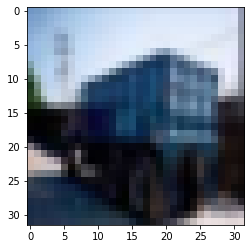

In [23]:
tf_image = next(iter(dataset))

plt.imshow(tf_image[0])
plt.show()

### label과 함께 batch로 묶기

하지만 불완전하게 끝난다 이후 tensorflow를 이용해서 label과 onehotencoding을 할것이다

In [24]:
path

'cifar/train\\0_frog.png'

In [27]:
path.split('_')[-1].replace('.png','')

'frog'

In [28]:
def get_label(path):
    return path.split('_')[-1].replace('.png','')

In [29]:
path, get_label(path)

('cifar/train\\0_frog.png', 'frog')

In [30]:
label_names = [get_label(path) for path in data_paths]

#### one hot encoding하기

In [33]:
class_names = np.unique(label_names)
class_names

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [34]:
one_hot_encoding = np.array(class_names =='frog', np.uint8)
one_hot_encoding

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [43]:
def one_hot_encoding(label):
    return  np.array(class_names =='label', np.uint8)

#### 함수로 만들기

In [44]:
def read_image_label(path, label):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    return image, label

In [45]:
dataset = tf.data.Dataset.from_tensor_slices((data_paths, label_names)) # 취치와 이름
dataset = dataset.map(read_image_label) #이미지를 가져온다
dataset = dataset.batch(batch_size)
# shuffle은 생략 dataset = dataset.shuffle(buffer_size = len(data_paths))
# repeat은 꼭해야한다
dataset = dataset.repeat()

In [46]:
image, label = next(iter(dataset))

In [47]:
image.shape, label.shape

(TensorShape([8, 32, 32, 3]), TensorShape([8]))

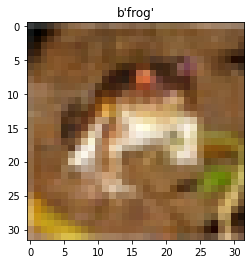

In [50]:
plt.imshow(image[0])
plt.title(np.array(label[0]))
plt.show()

이제 frog을 onehotencoding을 통해 label로 넣어야한다
tf.py_function()을 통해 처리해야한다

여기선 skip

### tensorflow 함수로 label과 onehotencoding 하기 예시

In [51]:
path

'cifar/train\\0_frog.png'

In [56]:
fname = tf.strings.split(path,'_')[-1]
fname

<tf.Tensor: shape=(), dtype=string, numpy=b'frog.png'>

In [63]:
cls_name = tf.strings.regex_replace(fname,'.png','')
cls_name

<tf.Tensor: shape=(), dtype=string, numpy=b'frog'>

In [64]:
class_names #아까 얻음

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [67]:
onehot_encoding = tf.cast(class_names == cls_name, tf.uint8)
onehot_encoding

<tf.Tensor: shape=(10,), dtype=uint8, numpy=array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)>

함수로 만들기

In [68]:
def get_label(path):
    fname = tf.strings.split(path,'_')[-1]
    cls_name = tf.strings.regex_replace(fname,'.png','')
    # class_names를 구해야한다
    onehot_encoding = tf.cast(class_names == cls_name, tf.uint8)
    return onehot_encoding

이제 이미지와 label을 동시에 가져오자

In [69]:
def read_image_label(path):
    # read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    # get label
    label = get_label(path)
    return image, label

In [70]:
dataset = tf.data.Dataset.from_tensor_slices(data_paths) # 위치
dataset = dataset.map(read_image_label) #이미지를 가져온다
dataset = dataset.batch(batch_size)
# shuffle은 생략 dataset = dataset.shuffle(buffer_size = len(data_paths))
# repeat은 꼭해야한다
dataset = dataset.repeat()

In [71]:
image, data = next(iter(dataset))

In [73]:
image.shape, data.shape #이미지와 onehotencoding됨

(TensorShape([8, 32, 32, 3]), TensorShape([8, 10]))

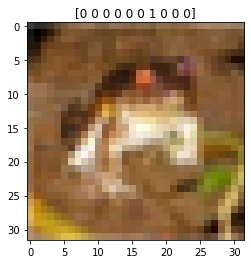

In [77]:
plt.title(np.array(data[0]))
plt.imshow(image[0])
plt.show()